In [1]:
# Import Libraries
import numpy as np
import cv2
import matplotlib.pylab as plt
import skimage.io
from skimage.filters import threshold_otsu
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib qt 

In [2]:
# Define functions

def neighbours(x,y,image):
    "Return 8-neighbours of image point P1(x,y), in a clockwise order"
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
    return [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],     # P2,P3,P4,P5
                img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]    # P6,P7,P8,P9

def transitions(neighbours):
    "No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence"
    n = neighbours + neighbours[0:1]      # P2, P3, ... , P8, P9, P2
    return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )  # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2)

def zhangSuen(image):
    "the Zhang-Suen Thinning Algorithm"
    Image_Thinned = image.copy()  # deepcopy to protect the original image
    changing1 = changing2 = 1        #  the points to be removed (set as 0)
    while changing1 or changing2:   #  iterates until no further changes occur in the image
        # Step 1
        changing1 = []
        rows, columns = Image_Thinned.shape               # x for rows, y for columns
        for x in range(1, rows - 1):                     # No. of  rows
            for y in range(1, columns - 1):            # No. of columns
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1     and    # Condition 0: Point P1 in the object regions 
                    2 <= sum(n) <= 6   and    # Condition 1: 2<= N(P1) <= 6
                    transitions(n) == 1 and    # Condition 2: S(P1)=1  
                    P2 * P4 * P6 == 0  and    # Condition 3   
                    P4 * P6 * P8 == 0):         # Condition 4
                    changing1.append((x,y))
        for x, y in changing1: 
            Image_Thinned[x][y] = 0
        # Step 2
        changing2 = []
        for x in range(1, rows - 1):
            for y in range(1, columns - 1):
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1   and        # Condition 0
                    2 <= sum(n) <= 6  and       # Condition 1
                    transitions(n) == 1 and      # Condition 2
                    P2 * P4 * P8 == 0 and       # Condition 3
                    P2 * P6 * P8 == 0):            # Condition 4
                    changing2.append((x,y))    
        for x, y in changing2: 
            Image_Thinned[x][y] = 0
    return Image_Thinned

In [3]:
# 0 - Load the image in grayscale
img = cv2.imread('sample1.jpg',cv2.IMREAD_GRAYSCALE)
inv_img = (255-img)

In [4]:
# 1 - IMAGE PROCESSING

# APPLY OTSU THRESHOLDING must set object region as 1, background region as 0 !
#otsu_thres = threshold_otsu(img)  
#bw_img = (inv_img) < otsu_thres    # for some reason it doesnt work well. Must double check

# APPLY simple thresholding
ret,thresh1 = cv2.threshold(inv_img,55,255,cv2.THRESH_BINARY)
bw_img = thresh1.astype(bool)
# Do some thining

# Perform the distance transform algorithm
#dist = cv2.distanceTransform(thresh1, cv2.DIST_L2, 3)
# Normalize the distance image for range = {0.0, 1.0}
# so we can visualize and threshold it
#cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)

# APPLY ZHANG SUEN THINING 
BW_Skeleton = zhangSuen(bw_img)
# BW_Skeleton = BW_Original


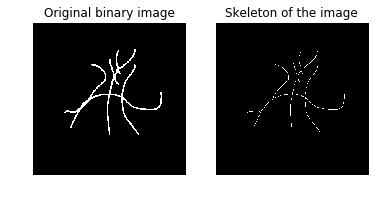

In [5]:
# 1.1 DISPLAY THINNING RESULT
fig, ax = plt.subplots(1, 2)
ax1, ax2 = ax.ravel()
ax1.imshow(bw_img, cmap=plt.cm.gray)
ax1.set_title('Original binary image')
ax1.axis('off')
ax2.imshow(BW_Skeleton, cmap=plt.cm.gray)
ax2.set_title('Skeleton of the image')
ax2.axis('off')
plt.show()

In [6]:
# 2 - IMAGE SEGMENTATION

#Find the corners
corners = cv2.goodFeaturesToTrack(inv_img, 100, 0.5, 10)


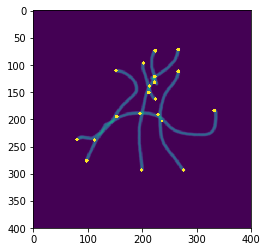

In [7]:
# 2.1 Display corners
k_img = np.copy(inv_img)
for corner in corners:
    x,y = corner.ravel()
    cv2.circle(k_img,(x,y),3,255,-1)

plt.imshow(k_img)
plt.show()

In [79]:
final_img = BW_Skeleton.astype(np.uint8)*255
cv2.imshow('image',final_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# Set Map
grid =  np.zeros((15,15))
grid[:,0] = 1
grid[14,:] = 1

print(grid)


In [ ]:
# each point must have: 
# coordinate
# S = distance from source
# D = distance from destiny
# M = S + D

class position_point():
    def __init__(self, pos_v, pos_h):
        self.pos_v = pos_v
        self.pos_h = pos_h
        
    def calc_distance(self, ref):
        return np.sqrt(((self.pos_v-ref.pos_v)**2)+((self.pos_h-ref.pos_h)**2))*10

    def calc_walk(self, src, dst):
        self.S = self.calc_distance(src)
        self.D = self.calc_distance(dst)
        self.M = self.S + self.D
        
start = position_point(2,0)
p1 = position_point(0,0)
goal = position_point(4,4)
p1.calc_walk(start,goal)
print(p1.S, p1.D, p1.M)

# YOU STOPPED HERE; you were trying to create a a-star algorithm to trace the path between two corners in the plot

In [ ]:



#def a_star( graph, start, goal):
open_set = set()
closed_set = []
path = []

# Calculate the costs for the starting point.
start.calc_walk(start,goal)
open_set.add(start)
cc = 1

while len(open_set) is not 0:
    cc+=1
    # set the current node as the one with the lowest M cost
    current = min(open_set, key=lambda inst:inst.M)
    print(current.pos_v,current.pos_h,current.S,current.D,current.M)
    # Move node from the open set to the closed set
    open_set.remove(current)
    closed_set.append(current)

    # did it reach the end? if yes return the path
    if (current.pos_v,current.pos_h) == (end.pos_v,end.pos_h): #cc == 20:
        break
        #return "the path vector"

    # Find all the neighbors that are in valid nodes
    clockwise_neighbors = np.asarray([[-1,0],[-1,1],[0,1],[1,1],[1,0],[1,-1],[0,-1],[-1,-1]])
    valid_neighbors = []
    node = np.asarray((current.pos_v,current.pos_h))
    for i,neig in enumerate(clockwise_neighbors):
        cur_point = node + neig
        if cur_point[0] >= 0 and cur_point[0] < grid.shape[0] and cur_point[1] < grid.shape[1] and cur_point[1] >=0 and grid[cur_point[0],cur_point[1]] == 1:
            closed_list = []
            for closed in closed_set:
                closed_list.append((closed.pos_v,closed.pos_h))
            if (cur_point[0],cur_point[1])  not in closed_list:
                node_to_append = np.ndarray.tolist(cur_point.astype(np.uint8))
                #print(node_to_append)
                vp = position_point(node_to_append[0],node_to_append[1])
                vp.calc_walk( start, goal)
                open_set.add(vp)


   

# This code loads the matrix and the corner coordinates

222.0 132.0
236.0 203.0
229.0 191.0
223.0 122.0
212.0 151.0
224.0 74.0
266.0 72.0
98.0 276.0
276.0 293.0
152.0 111.0
196.0 189.0
332.0 184.0
199.0 293.0
202.0 97.0
112.0 238.0
224.0 163.0
266.0 112.0
80.0 237.0
153.0 195.0
213.0 139.0


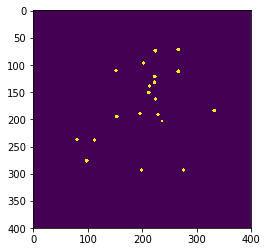

In [159]:
grid = np.copy(BW_Skeleton.astype(np.uint8))
#k_img = np.copy(inv_img)
for corner in corners:
    x,y = corner.ravel()
    print(x,y)
    cv2.circle(grid,(x,y),3,255,-1)

plt.imshow(grid)
plt.show()


# this code runs the function

x,y = corners[0][0].astype(np.uint8)
start = position_point(y,x)
x,y = corners[5][0].astype(np.uint8)
goal = position_point(y,x)
print(x,y)
a_star( grid, start, goal)

# SOMEBODY ELSES IMPLEMENTATION OF ASTAR

In [138]:
from astar import AStar
import sys
import math


def make_maze(w=5, h=5):
    """returns an ascii maze as a string"""
    from random import shuffle, randrange
    vis = [[0] * w + [1] for _ in range(h)] + [[1] * (w + 1)]
    ver = [["|  "] * w + ['|'] for _ in range(h)] + [[]]
    hor = [["+--"] * w + ['+'] for _ in range(h + 1)]

    def walk(x, y):
        vis[y][x] = 1

        d = [(x - 1, y), (x, y + 1), (x + 1, y), (x, y - 1)]
        shuffle(d)
        for (xx, yy) in d:
            if vis[yy][xx]:
                continue
            if xx == x:
                hor[max(y, yy)][x] = "+  "
            if yy == y:
                ver[y][max(x, xx)] = "   "
            walk(xx, yy)

    walk(randrange(w), randrange(h))
    result = ''
    for (a, b) in zip(hor, ver):
        result = result + (''.join(a + ['\n'] + b)) + '\n'
    return result.strip()


def drawmaze(maze, set1=[], set2=[], c='#', c2='*'):
    """returns an ascii maze, drawing eventually one (or 2) sets of positions.
        useful to draw the solution found by the astar algorithm
    """
    set1 = list(set1)
    set2 = list(set2)
    lines = maze.strip().split('\n')
    width = len(lines[0])
    height = len(lines)
    result = ''
    for j in range(height):
        for i in range(width):
            if (i, j) in set1:
                result = result + c
            elif (i, j) in set2:
                result = result + c2
            else:
                result = result + lines[j][i]
        result = result + '\n'
    return result


class MazeSolver(AStar):

    """sample use of the astar algorithm. In this exemple we work on a maze made of ascii characters,
    and a 'node' is just a (x,y) tuple that represents a reachable position"""

    def __init__(self, maze):
        self.lines = maze.strip().split('\n')
        self.width = len(self.lines[0])
        self.height = len(self.lines)

    def heuristic_cost_estimate(self, n1, n2):
        """computes the 'direct' distance between two (x,y) tuples"""
        (x1, y1) = n1
        (x2, y2) = n2
        return math.hypot(x2 - x1, y2 - y1)

    def distance_between(self, n1, n2):
        """this method always returns 1, as two 'neighbors' are always adajcent"""
        return 1

    def neighbors(self, node):
        """ for a given coordinate in the maze, returns up to 4 adjacent(north,east,south,west)
            nodes that can be reached (=any adjacent coordinate that is not a wall)
        """
        x, y = node
        return[(nx, ny) for nx, ny in[(x, y - 1), (x, y + 1), (x - 1, y), (x + 1, y)]if 0 <= nx < self.width and 0 <= ny < self.height and self.lines[ny][nx] == ' ']

# generate an ascii maze
size = 5
m = make_maze(size, size)

# what is the size of it?
w = len(m.split('\n')[0])
h = len(m.split('\n'))

start = (1, 1)  # we choose to start at the upper left corner
goal = (w - 2, h - 2)  # we want to reach the lower right corner

# let's solve it
foundPath = list(MazeSolver(m).astar(start, goal))

# print the solution
print(drawmaze(m, list(foundPath)))

+--+--+--+--+--+
|####### |     |
+--+  +# +--+  +
|     |# | ### |
+--+--+# + #+# +
|  | ### | #|# |
+  + #+--+ #+# +
|  | #######|# |
+  +--+--+--+# +
|            ##|
+--+--+--+--+--+



In [14]:
import cv2 as cv
import numpy as np
input_image = BW_Skeleton.astype(np.uint8)
np.array((
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 255, 255, 255, 0, 0, 0, 255],
    [0, 255, 255, 255, 0, 0, 0, 0],
    [0, 255, 255, 255, 0, 255, 0, 0],
    [0, 0, 255, 0, 0, 0, 0, 0],
    [0, 0, 255, 0, 0, 255, 255, 0],
    [0,255, 0, 255, 0, 0, 255, 0],
    [0, 255, 255, 255, 0, 0, 0, 0]), dtype="uint8")
kernel = np.array((
        [0, 1, 0],
        [1, -1, 1],
        [0, 1, 0]), dtype="int")
output_image = cv.morphologyEx(input_image, cv.MORPH_HITMISS, kernel)


rate = 50
kernel = (kernel + 1) * 127
kernel = np.uint8(kernel)
kernel = cv.resize(kernel, None, fx = rate, fy = rate, interpolation = cv.INTER_NEAREST)
cv.imshow("kernel", kernel)
cv.moveWindow("kernel", 0, 0)
input_image = cv.resize(input_image, None, fx = rate, fy = rate, interpolation = cv.INTER_NEAREST)
cv.imshow("Original", input_image)
cv.moveWindow("Original", 0, 200)
output_image = cv.resize(output_image, None , fx = rate, fy = rate, interpolation = cv.INTER_NEAREST)
cv.imshow("Hit or Miss", output_image)
cv.moveWindow("Hit or Miss", 500, 200)
cv.waitKey(0)
cv.destroyAllWindows()

In [13]:
np.max(BW_Skeleton.astype(np.uint8))



1